# Spaceship Titanic – Exploratory Data Analysis

This notebook performs a rigorous exploratory data analysis (EDA) for the Kaggle **Spaceship Titanic** competition.

- **Train file**: `train.csv` (contains the binary target `Transported`)
- **Test file**: `test.csv` (no target)

Goals of this EDA:
- Understand basic distributions of all features.
- Compare distributions across the target label `Transported`.
- Investigate correlations and relationships between features.
- Identify sensible feature engineering opportunities (e.g. splitting `PassengerId`, `Cabin`, `Name`).
- Build intuition that will inform later model design choices.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# plotting defaults to avoid wonky plots in jupyter
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# included in case prof or TA wants to run as kaggle notebook instead of with jupyter
kaggle_dir = "/kaggle/input/spaceship-titanic"
if os.path.exists(os.path.join(kaggle_dir, "train.csv")):
    DATA_DIR = kaggle_dir
else:
    DATA_DIR = "from_kaggle"

train_path = os.path.join(DATA_DIR, "train.csv")
test_path = os.path.join(DATA_DIR, "test.csv")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Dataset Overview
shapes, dtypes, and basic summary stats

In [2]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)

print("\nTrain columns and dtypes:")
print(train.dtypes)

print("\nTest columns and dtypes:")
print(test.dtypes)

print("\nTarget distribution (Transported):")
print(train["Transported"].value_counts(dropna=False))
print("\nTarget rate:")
print(train["Transported"].value_counts(normalize=True))


Train shape: (8693, 14)
Test shape : (4277, 13)

Train columns and dtypes:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Test columns and dtypes:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

Target distribution (Transported):
True     4378
False    4315
Name: Transported, dtype: int64

Target rate:
True     0.503624
False    0.496376
Name: Transported, dtype: float64


Target distribution is roughly balanced

### Missing Values
To see if we need to do imputation, drop rows, etc

In [3]:
def summarize_missing(df, name):
    na_counts = df.isna().sum().sort_values(ascending=False)
    na_pct = (na_counts / len(df)).round(4)
    missing_df = pd.DataFrame({
        "n_missing": na_counts,
        "pct_missing": na_pct
    })
    print(f"Missing values summary for {name}:")
    return missing_df[missing_df["n_missing"] > 0]

missing_train = summarize_missing(train, "train")
display(missing_train)

print()
missing_test = summarize_missing(test, "test")
display(missing_test)


Missing values summary for train:


,n_missing,pct_missing
CryoSleep,217,0.0250
ShoppingMall,208,0.0239
VIP,203,0.0234
HomePlanet,201,0.0231
Name,200,0.0230
Cabin,199,0.0229
VRDeck,188,0.0216
FoodCourt,183,0.0211
Spa,183,0.0211
Destination,182,0.0209



Missing values summary for test:


,n_missing,pct_missing
FoodCourt,106,0.0248
Spa,101,0.0236
Cabin,100,0.0234
ShoppingMall,98,0.0229
Name,94,0.0220
CryoSleep,93,0.0217
VIP,93,0.0217
Destination,92,0.0215
Age,91,0.0213
HomePlanet,87,0.0203


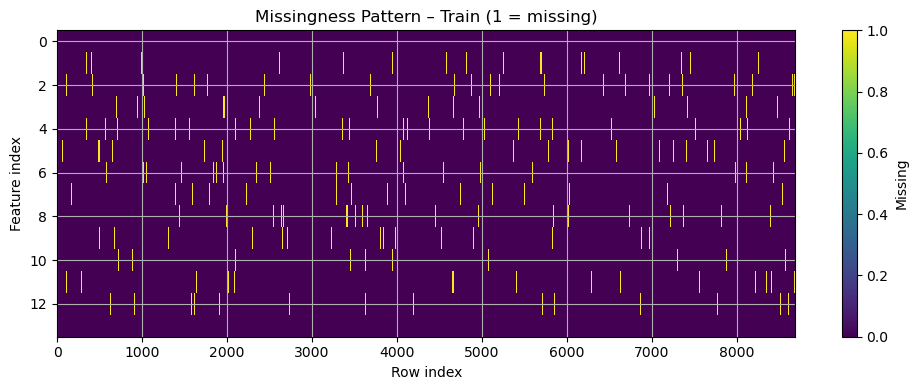

In [4]:
# visualize missingness pattern for train
missing_matrix = train.isna().astype(int)

plt.figure(figsize=(10, 4))
plt.imshow(missing_matrix.T, aspect="auto", interpolation="nearest")
plt.title("Missingness Pattern – Train (1 = missing)")
plt.xlabel("Row index")
plt.ylabel("Feature index")
plt.colorbar(label="Missing")
plt.tight_layout()
plt.show()


Not much visible pattern in missing data. Data is missing throughout, so maybe imputation would be better than dropping rows with lots of missing data. This will become more clear with data distributions.

### Identify Feature Types
Separate features into broadly **numeric**, **boolean**, and **categorical/string** to guide plotting choices

In [5]:
target_col = "Transported"

feature_cols = [c for c in train.columns if c != target_col]

# basic type categorization (can be refined if needed)
bool_cols = [c for c in feature_cols if train[c].dropna().isin([0, 1, True, False]).all()]
num_cols  = [c for c in feature_cols if train[c].dtype != "object" and c not in bool_cols]
cat_cols  = [c for c in feature_cols if train[c].dtype == "object"]

print("Boolean features:", bool_cols)
print("Numeric features:", num_cols)
print("Categorical/string features:", cat_cols)


Boolean features: ['CryoSleep', 'VIP']
Numeric features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical/string features: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


# Univariate Distributions
Look at numeric and categorical features individually to understand their ranges, skew, etc

### Numeric Features

In [6]:
train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


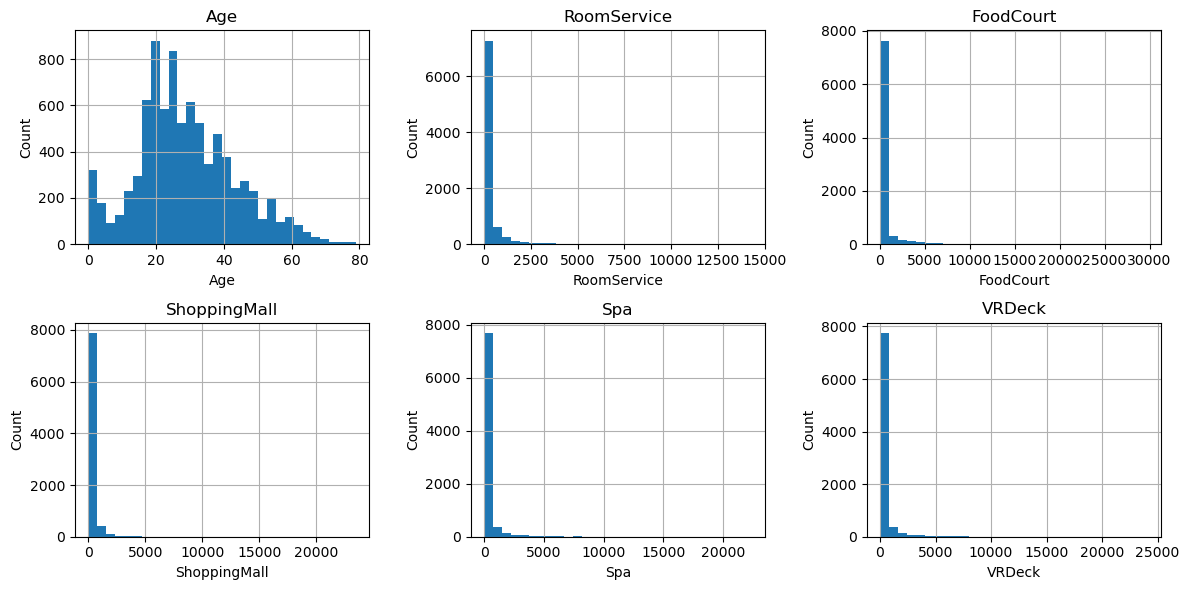

In [7]:
# histograms for numeric features
n = len(num_cols)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(train[col].dropna(), bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Categorical / Boolean Features

Categorical cardinality:


,n_unique
PassengerId,8693
Name,8473
Cabin,6560
HomePlanet,3
Destination,3
CryoSleep,2
VIP,2


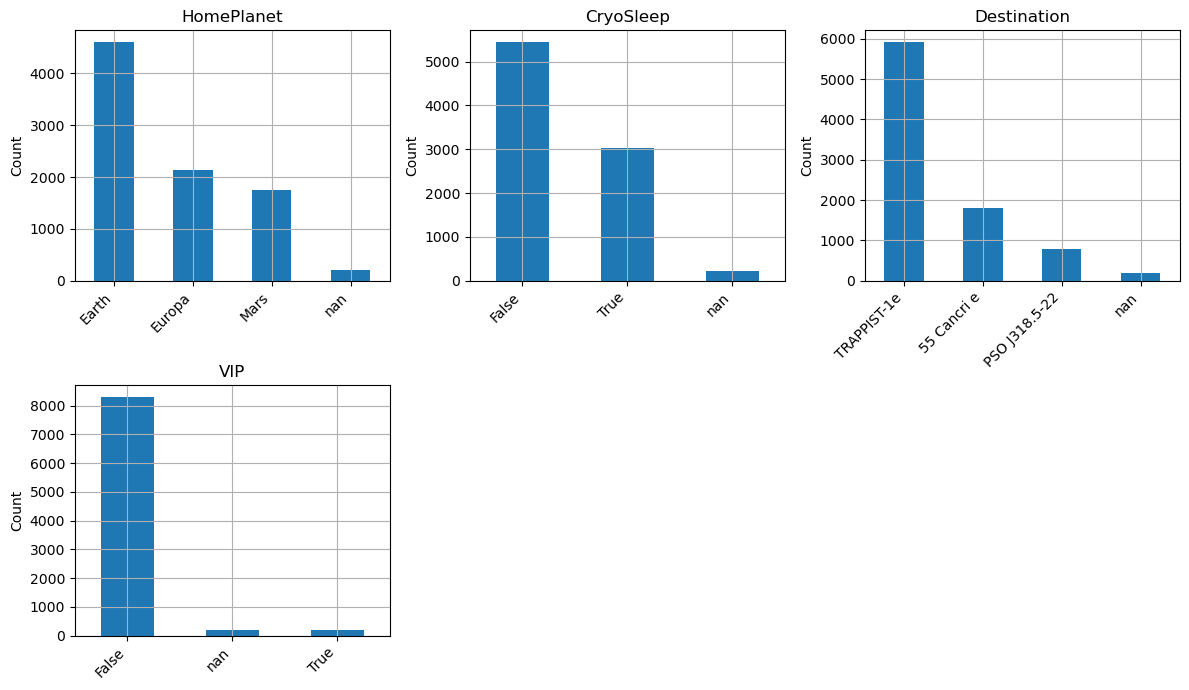

In [8]:
# cardinality
card = train[cat_cols].nunique().sort_values(ascending=False)
print("Categorical cardinality:")
display(card.to_frame("n_unique"))

# frequency plots for low cardinality vars
max_unique_for_plot = 20
small_cat_cols = [c for c in cat_cols if train[c].nunique() <= max_unique_for_plot]

n = len(small_cat_cols)
n_cols = 3
n_rows = int(np.ceil(n / n_cols)) if n > 0 else 0

if n > 0:
    plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))
    for i, col in enumerate(small_cat_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        train[col].value_counts(dropna=False).plot(kind="bar")
        plt.title(col)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [9]:
# boolean features distribution
for col in bool_cols:
    print(f"\nValue counts for {col}:")
    print(train[col].value_counts(dropna=False))



Value counts for CryoSleep:
False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64

Value counts for VIP:
False    8291
NaN       203
True      199
Name: VIP, dtype: int64


# Target vs Feature Relationships
Look at how feature distributions differ by the target `Transported` to identify strong predictors and possible feature interactions.

### Numeric Features vs Target

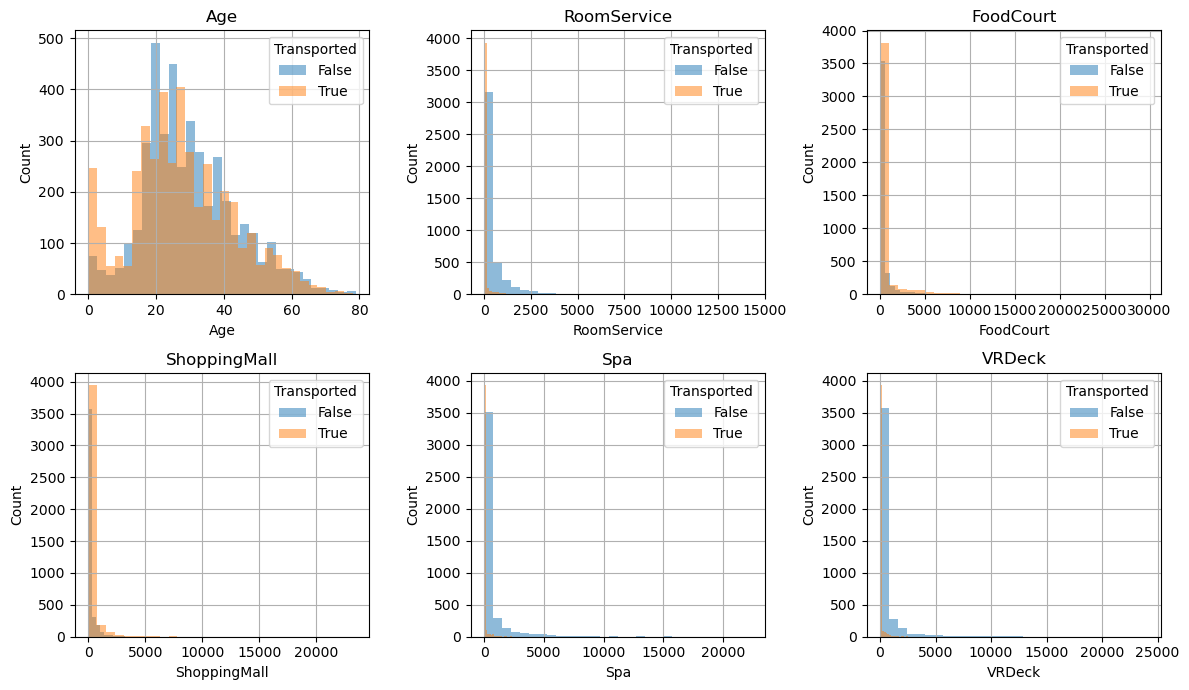

In [10]:
# overlay histograms by target for numeric features
n = len(num_cols)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    for label, subset in train.groupby(target_col):
        plt.hist(
            subset[col].dropna(),
            bins=30,
            alpha=0.5,
            label=str(label)
        )
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title=target_col)
plt.tight_layout()
plt.show()


In [11]:
# Mean and median of numeric features by target
grouped_num = train.groupby(target_col)[num_cols].agg(["mean", "median"])
grouped_num


Age        RoomService          FoodCourt         \
                  mean median        mean median        mean median   
Transported                                                           
False        29.922858   27.0  389.266066    1.0  382.615930    0.0   
True         27.748834   26.0   63.098021    0.0  532.691984    0.0   

            ShoppingMall                Spa             VRDeck         
                    mean median        mean median        mean median  
Transported                                                            
False         167.566217    0.0  564.382666    4.0  543.629822    1.0  
True          179.829972    0.0   61.675531    0.0   69.148131    0.0

### Categorical / Boolean Features vs Target


=== HomePlanet ===


,transported_rate,n
HomePlanet,,
Europa,0.658846,2131
Mars,0.523024,1759
Earth,0.423946,4602


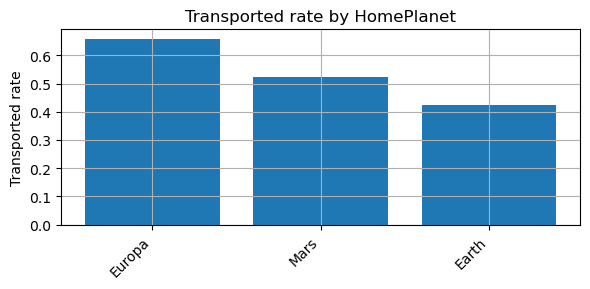


=== CryoSleep ===


,transported_rate,n
CryoSleep,,
True,0.817583,3037
False,0.328921,5439


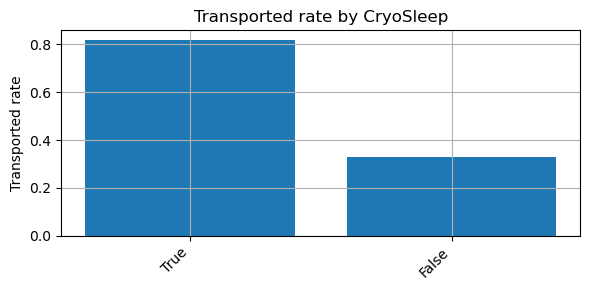


=== Destination ===


,transported_rate,n
Destination,,
55 Cancri e,0.610000,1800
PSO J318.5-22,0.503769,796
TRAPPIST-1e,0.471175,5915


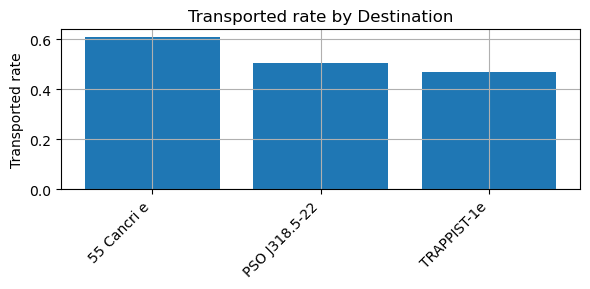


=== VIP ===


,transported_rate,n
VIP,,
False,0.506332,8291
True,0.381910,199


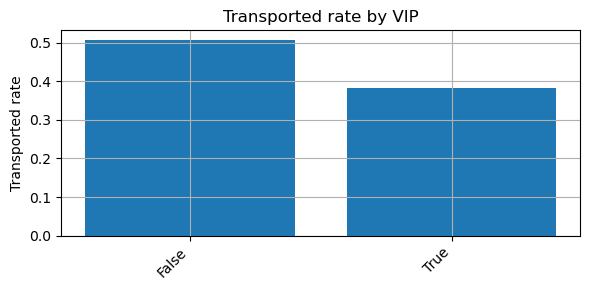


=== CryoSleep ===


,transported_rate,n
CryoSleep,,
True,0.817583,3037
False,0.328921,5439


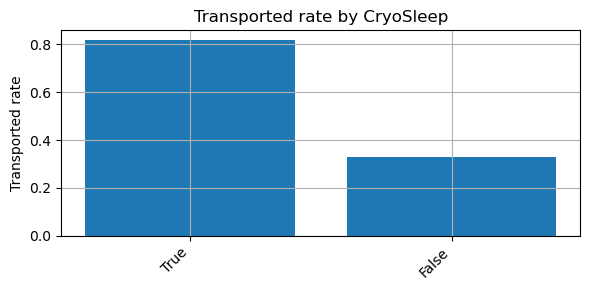


=== VIP ===


,transported_rate,n
VIP,,
False,0.506332,8291
True,0.381910,199


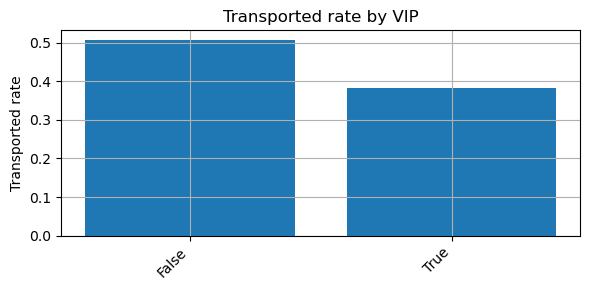

In [12]:
def target_rate_by_category(df, cat, target):
    tab = (
        df.groupby(cat)[target]
        .agg(["mean", "count"])
        .rename(columns={"mean": "transported_rate", "count": "n"})
        .sort_values("transported_rate", ascending=False)
    )
    return tab

for col in small_cat_cols + bool_cols:
    print(f"\n=== {col} ===")
    tab = target_rate_by_category(train, col, target_col)
    display(tab.head(20))

    # Bar plot of transported rate
    plt.figure(figsize=(6, 3))
    plt.bar(tab.index.astype(str), tab["transported_rate"])
    plt.title(f"Transported rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Transported rate")
    plt.tight_layout()
    plt.show()


# Correlation Structure
Look at the correlation matrix for numeric and boolean features

In [13]:
# encode boolean features as int to include them in correlations
train_corr = train.copy()
for col in bool_cols + [target_col]:
    train_corr[col] = train_corr[col].astype(float)

corr_cols = num_cols + bool_cols + [target_col]
corr_matrix = train_corr[corr_cols].corr()

corr_matrix[target_col].sort_values(ascending=False)


Transported     1.000000
CryoSleep       0.468645
FoodCourt       0.046566
ShoppingMall    0.010141
VIP            -0.037650
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

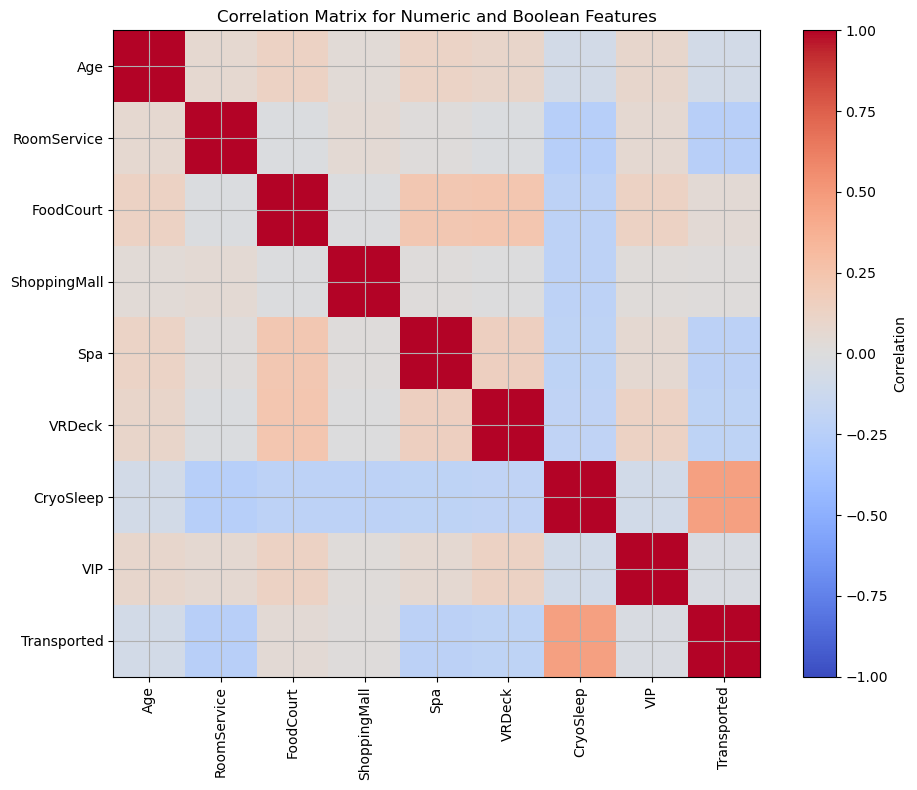

In [14]:
# heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=90)
ax.set_yticklabels(corr_cols)
fig.colorbar(im, ax=ax, label="Correlation")
plt.title("Correlation Matrix for Numeric and Boolean Features")
plt.tight_layout()
plt.show()


# Feature Engineering Exploration
The data has several structured string fields that can be decomposed into smaller, more informative pieces:

- **PassengerId** is formatted as `group_passenger`, where passengers with the same group ID might travel together
- **Cabin** is formatted as `deck/num/side`, where `deck` and `side` may be informative
- **Name** is composed of `FirstName LastName`, where family groups may share surnames and might travel together

In [15]:
fe_train = train.copy()
fe_test = test.copy()

def split_passenger_id(df):
    gid_pid = df["PassengerId"].str.split("_", expand=True)
    df["PassengerGroup"] = gid_pid[0]
    df["PassengerNumber"] = gid_pid[1].astype(int)

def split_cabin(df):
    # cabin format: deck/num/side
    cabin_split = df["Cabin"].str.split("/", expand=True)
    df["CabinDeck"] = cabin_split[0]
    df["CabinNum"] = cabin_split[1]
    df["CabinSide"] = cabin_split[2]

def split_name(df):
    # cast word as surname, rest as given name(s)
    names = df["Name"].fillna("Unknown Unknown")
    parts = names.str.rsplit(" ", n=1, expand=True)
    df["Surname"] = parts[1]
    df["GivenNames"] = parts[0]

split_passenger_id(fe_train)
split_passenger_id(fe_test)
split_cabin(fe_train)
split_cabin(fe_test)
split_name(fe_train)
split_name(fe_test)

fe_train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,PassengerGroup,PassengerNumber,CabinDeck,CabinNum,CabinSide,Surname,GivenNames
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0001,1,B,0,P,Ofracculy,Maham
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,0002,1,F,0,S,Vines,Juanna
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0003,1,A,0,S,Susent,Altark
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0003,2,A,0,S,Susent,Solam
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,0004,1,F,1,S,Santantines,Willy


### Passenger Groups & Transported Rate

In [16]:
# group level transported rate
group_stats = (
    fe_train.groupby("PassengerGroup")[target_col]
    .agg(["mean", "count"])
    .rename(columns={"mean": "transported_rate", "count": "group_size"})
)

group_stats.sort_values("transported_rate", ascending=False).head()


,transported_rate,group_size
PassengerGroup,,
6304,1.0,1
6848,1.0,1
6843,1.0,2
7837,1.0,2
4987,1.0,1


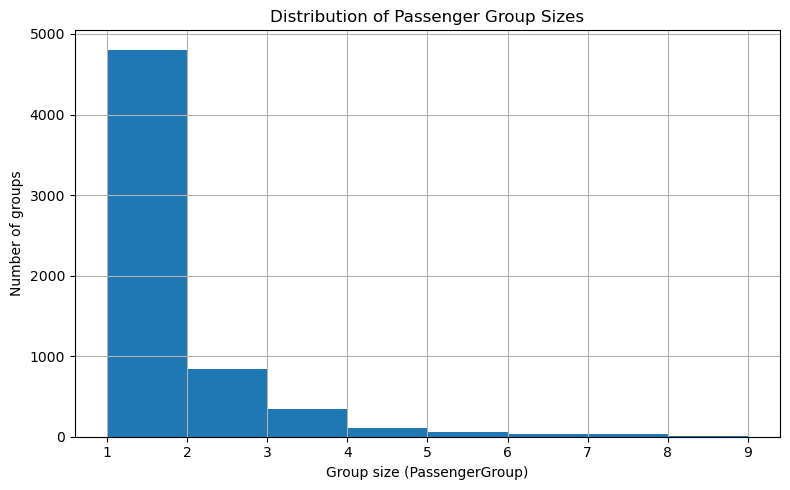

In [17]:
# distribution of group sizes
plt.hist(group_stats["group_size"], bins=range(1, group_stats["group_size"].max() + 2))
plt.xlabel("Group size (PassengerGroup)")
plt.ylabel("Number of groups")
plt.title("Distribution of Passenger Group Sizes")
plt.tight_layout()
plt.show()


### Cabin Decomposition


=== CabinDeck ===


,transported_rate,n
CabinDeck,,
B,0.734275,779
C,0.680054,747
G,0.516217,2559
A,0.496094,256
F,0.439871,2794
D,0.433054,478
E,0.357306,876
T,0.200000,5


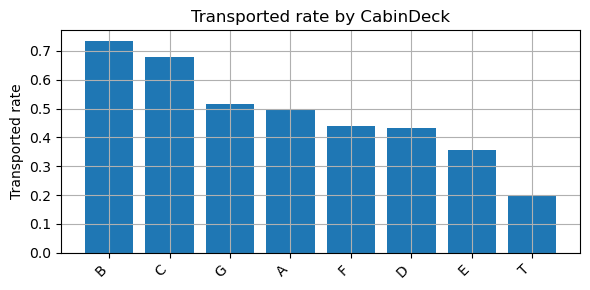


=== CabinSide ===


,transported_rate,n
CabinSide,,
S,0.555037,4288
P,0.451260,4206


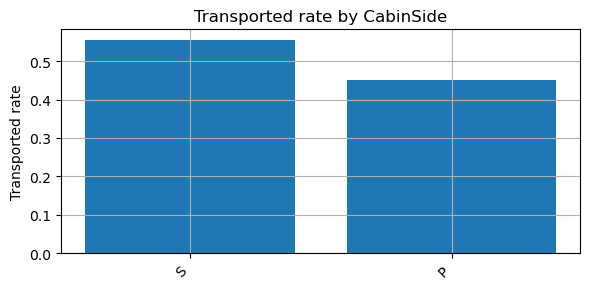

In [18]:
# inspect cardinality and target rate by CabinDeck and CabinSide
for col in ["CabinDeck", "CabinSide"]:
    print(f"\n=== {col} ===")
    tab = (
        fe_train.groupby(col)[target_col]
        .agg(["mean", "count"])
        .rename(columns={"mean": "transported_rate", "count": "n"})
        .sort_values("transported_rate", ascending=False)
    )
    display(tab)

    plt.figure(figsize=(6, 3))
    plt.bar(tab.index.astype(str), tab["transported_rate"])
    plt.title(f"Transported rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Transported rate")
    plt.tight_layout()
    plt.show()


### Surnames and Possible Family Effects

In [19]:
# count how many passengers share each surname
surname_counts = fe_train["Surname"].value_counts()
surname_counts.head()


Unknown      200
Casonston     18
Oneiles       16
Domington     15
Litthews      15
Name: Surname, dtype: int64

In [20]:
# transported rate for top shared surnames (size >= 3)
frequent_surnames = surname_counts[surname_counts >= 3].index
surname_stats = (
    fe_train[fe_train["Surname"].isin(frequent_surnames)]
    .groupby("Surname")[target_col]
    .agg(["mean", "count"])
    .rename(columns={"mean": "transported_rate", "count": "n"})
    .sort_values("transported_rate", ascending=False)
)
surname_stats.head(20)


,transported_rate,n
Surname,,
Fruidy,1.0,3
Brakeng,1.0,6
Singlents,1.0,3
Singmage,1.0,3
Bre,1.0,3
Volloor,1.0,4
Slavested,1.0,4
Sloweber,1.0,5
Griffince,1.0,5


# Spending Features and Derived Totals
Data provides several spending columns (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck). Look at them individually and as a combined total

In [21]:
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
fe_train["TotalSpend"] = fe_train[spending_cols].sum(axis=1)
fe_test["TotalSpend"] = fe_test[spending_cols].sum(axis=1)

fe_train[spending_cols + ["TotalSpend"]].describe().T


,count,mean,std,min,25%,50%,75%,max
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
TotalSpend,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


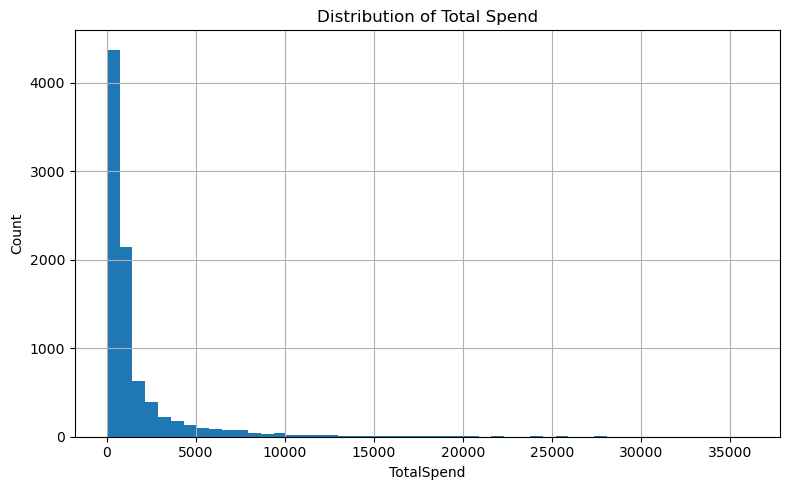

<Figure size 600x400 with 0 Axes>

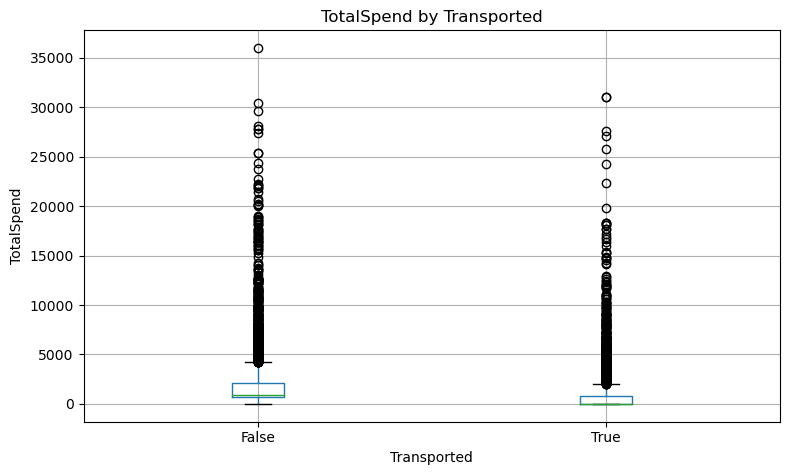

In [22]:
# distribution of total spend
plt.hist(fe_train["TotalSpend"].dropna(), bins=50)
plt.xlabel("TotalSpend")
plt.ylabel("Count")
plt.title("Distribution of Total Spend")
plt.tight_layout()
plt.show()

# total spend vs target
plt.figure(figsize=(6, 4))
fe_train.boxplot(column="TotalSpend", by=target_col)
plt.title("TotalSpend by Transported")
plt.suptitle("")
plt.xlabel(target_col)
plt.ylabel("TotalSpend")
plt.tight_layout()
plt.show()


# PCA and Clustering on Numeric Features
To explore higher-dimensional structure, PCA on scaled numeric features and visualize clusters using K-means. This can show if `Transported` aligns with naturally occurring groups in the feature space

In [23]:
# prepare numeric/boolean features for PCA/clustering
pca_features = num_cols + bool_cols + ["TotalSpend"]
pca_features = [c for c in pca_features if c in fe_train.columns]

pca_df = fe_train[pca_features].copy()

# simple imputation: fill NaN with median for PCA/clustering
for col in pca_features:
    pca_df[col] = pca_df[col].fillna(pca_df[col].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_df)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.29527414 0.13511592]


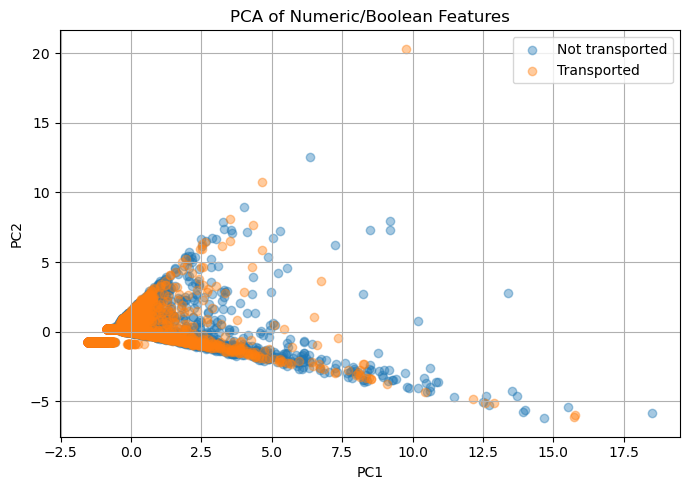

In [24]:
# scatter plot of first two principal components colored by Transported
plt.figure(figsize=(7, 5))
transported_mask = fe_train[target_col]

plt.scatter(
    X_pca[~transported_mask, 0],
    X_pca[~transported_mask, 1],
    alpha=0.4,
    label="Not transported"
)
plt.scatter(
    X_pca[transported_mask, 0],
    X_pca[transported_mask, 1],
    alpha=0.4,
    label="Transported"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Numeric/Boolean Features")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# KMeans clustering in PCA space
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

fe_train["Cluster"] = clusters

# transported rate by cluster
cluster_stats = (
    fe_train.groupby("Cluster")[target_col]
    .agg(["mean", "count"])
    .rename(columns={"mean": "transported_rate", "count": "n"})
)
cluster_stats


,transported_rate,n
Cluster,,
0,0.301939,4332
1,0.800230,3474
2,0.340819,757
3,0.246154,130


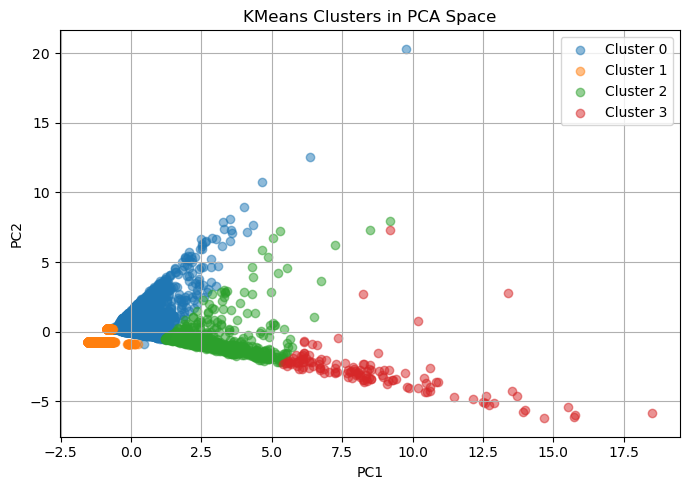

In [26]:
# visualize clusters in PCA space
plt.figure(figsize=(7, 5))
for c in sorted(fe_train["Cluster"].unique()):
    mask = fe_train["Cluster"] == c
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.5,
        label=f"Cluster {c}"
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA Space")
plt.legend()
plt.tight_layout()
plt.show()


# EDA Summary and Modeling Implications
Key observations to consider for downstream modeling might include:

- The target `Transported` has roughly balanced classes, which enables a variety of classification models without heavy rebalancing.
- Several features (**HomePlanet**, **Destination**, **CryoSleep**, **VIP**, **CabinDeck**, **CabinSide**, **TotalSpend**, **Age**) show some differences in distribution across the target
- Spending features are very skewed with many zeros
- Missingness is non-uniform across features (especially `Cabin`, `Age`, `VIP`, and spending fields). It may be useful to:
  - Use feature-specific imputation strategies (median for numeric, most frequent for categorical)
  - Add explicit missingness indicator features for highly informative columns
- Structured text fields (`PassengerId`, `Cabin`, `Name`) can be decomposed into multiple features that might be predictive
- PCA and clustering suggest some separation between transported and non-transported passengers in numeric feature space, hinting that non-linear models (tree-based ensembles, neural networks) may capture useful structure

These insights will guide future steps such as:
- Feature engineering (expanded group/family features, log/ratio features, interaction terms)
- Handling of missing values and skew
- Model selection among interpretable linear models, regularized logistic regression, and non-linear models like gradient boosting, random forests, and neural nets